# **Imports**

In [0]:
import torchvision
import torchvision.datasets as dset
import numpy as np
import PIL
import math  
import torch
import cv2
import glob

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as transforms
from matplotlib import pyplot as plt
from zipfile import ZipFile as Zip
from google.colab import files

%matplotlib inline

# **Consts**

In [0]:
FACE_BATCH_SIZE = 16
IMG_SIZE = 224

FACE_DATASET_PATH = "/content/StudentsFacesDataset"

In [0]:
!unrar x "/content/StudentsFacesDataset.rar"

# **Image Helper Class**

In [0]:
class Im(object):
    def __init__(self, path):
        self.path = path

        self.rgb_image = None
        self.bgr_image = None
        self.gray_image = None


    def read(self, return_image = False):
        self.rgb_image = plt.imread(self.path)
        if return_image:
            return self.rgb_image


    def bgr(self, return_image = False):
        self.bgr_image = np.flip(plt.imread(self.path), 2)
        if return_image:
            return self.bgr_image


    def gray(self, return_image = False):
        self.gray_image = cv2.cvtColor(plt.imread(self.path), cv2.COLOR_RGB2GRAY)
        if return_image:
            return self.gray_image


    @staticmethod
    def show(image, title = 'image'):
        if len(image.shape) == 3:
            plt.imshow(image)
        else:
            plt.imshow(image, cmap = 'gray')

        plt.axis('off')
        plt.title(title)


    @staticmethod
    def show_all(image_list, title_list):
        assert len(image_list) == len(title_list), "Incompatible lengths of lists!"
        N = len(image_list)
        plt.figure(figsize=[20, 20])

        for i in range(N):
            plt.subplot(1, N, i + 1)
            Im.show(image_list[i], title_list[i])
        
        plt.show()

# **Faces' Dataset / Dataloader Creation**

Dataset Class Definition

In [0]:
class FaceDataset(Dataset):
    def __init__(self, root_path, transform=None, train=True):
        super(FaceDataset, self).__init__()
        self.root_path = root_path
        pathes = glob.glob(root_path + "/*/*.jpg") # root_path is the dataset's path

        self.train_pathes = pathes[: int(len(pathes) * 0.8)] # 80% data for train
        self.test_pathes = pathes[int(len(pathes) * 0.8) :] # 20% data for test

        self.transform = transform
        self.train = train


    def __getitem__(self, idx):
        if self.train:
            p = self.train_pathes[idx]
        else:
            p = self.test_pathes[idx]

        x = cv2.imread(p)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        if self.transform:
            x = self.transform(x)

        temp_y = p[len(self.root_path) + 1 :]
        y = int(temp_y[: temp_y.find('/')])

        return x, y


    def __len__(self):
        if self.train:
            return len(self.train_pathes)
        else:
            return len(self.test_pathes)

Augmentations' definition

In [0]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-15, 15)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

**transforms.ToPILImage():** 

> This transformation is made because these Pytorch's transforms only support working with PIL image format. Therefore, it's necessary to convert images to this format before committing the rest of the augmentations.


**transforms.RandomHorizontalFlip(),**
**transforms.RandomRotation((-15, 15)),**
**transforms.ColorJitter(brightness=0.5, contrast=0.5,saturation=0.5):**

> These augmentations are for making the dataset more versatile than before. it doesn't ruin the images, due to cautious passed arguments as absolute of maximum 15 degrees rotation value and 0.5 maximum value for color changing augmentation by ColorJitter. It is important to notice that HorizontalFlip is the only flip which used, because it does not ruin the meaning of face images, as RandomCrop does. Other augmentations could also ruin the dataset and this is the reason they aren't chosen, for example, RandomVerticalFlip augmentation could harm some learning algorithms by causing the input "face object" to change its natural look to an unnatural one - an upside-down face.

**transforms.Resize((IMG_SIZE, IMG_SIZE)):**
> This transformation is necessary, because many of the learning algorithms support pictures which have the same shape. This also makes the learning process more homogeneous by treating the dataset's images the same way.

**transforms.ToTensor():**

> This transformation is made to support passing an image into a PyTorch neural network or other learning algorithms. It is done also because it needs to be converted into another image type for showing the image, which does not support a PIL image type.

**transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):**

> This transformation is made to make the learning algorithms better when they operate on such images, by subtracting the mean value and dividing by standard deviation.




In [0]:
# Face train dataloader creation
face_trainset = FaceDataset(FACE_DATASET_PATH, transform=train_transform)

# Face train dataloader creation
face_trainloader = DataLoader(face_trainset, batch_size=FACE_BATCH_SIZE, shuffle=True, num_workers=4)

In [0]:
# Face test dataloader creation
face_testset = FaceDataset(FACE_DATASET_PATH, transform=test_transform ,train=False)

# Face test dataloader creation
face_testloader = DataLoader(face_testset, batch_size=FACE_BATCH_SIZE, shuffle=True, num_workers=4)

Show image examples

In [0]:
# Train
it1 = iter(face_trainloader)
imgs1, lbls1 = next(it1)

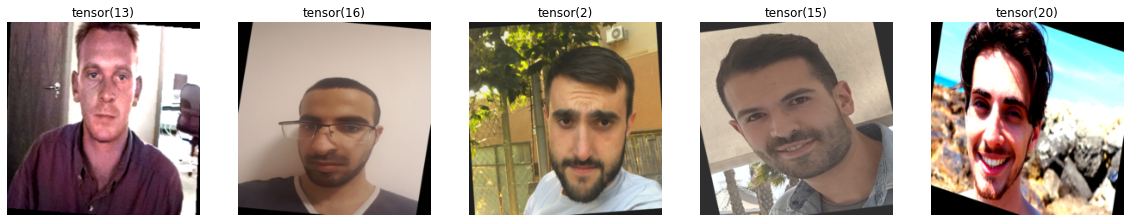

In [19]:
Im.show_all(imgs1.permute(0, 2, 3, 1)[0:5, :, :, :] * 0.5 + 0.5, lbls1[:5])

In [0]:
# Test
it2 = iter(face_testloader)
imgs2, lbls2 = next(it2)

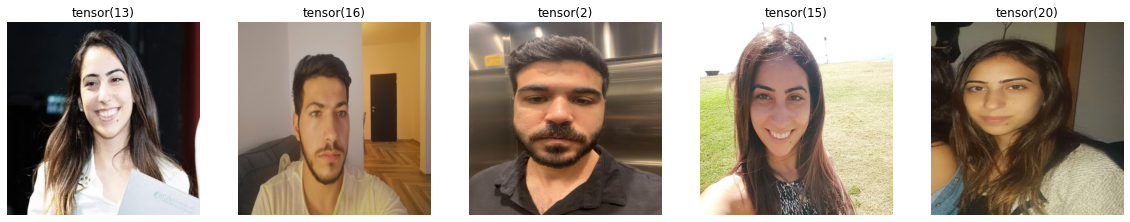

In [21]:
Im.show_all(imgs2.permute(0, 2, 3, 1)[0:5, :, :, :] * 0.5 + 0.5, lbls1[:5])

# **Read and show images**

In [0]:
img1 = plt.imread("me.jpg")
img2 = plt.imread("daniel.jpg")

g1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
g2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

In [0]:
img3 = plt.imread("anna.jpg")
img4 = plt.imread("rikki.jpg")

g3 = cv2.cvtColor(img3, cv2.COLOR_RGB2GRAY)
g4 = cv2.cvtColor(img4, cv2.COLOR_RGB2GRAY)

In [0]:
img5 = plt.imread("roman.jpg")
img6 = plt.imread("din.jpeg")

g5 = cv2.cvtColor(img5, cv2.COLOR_RGB2GRAY)
g6 = cv2.cvtColor(img6, cv2.COLOR_RGB2GRAY)

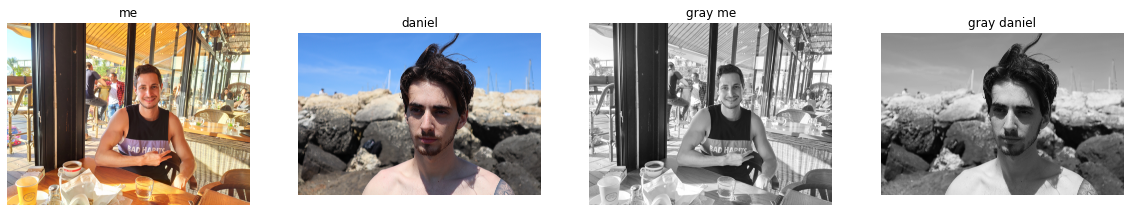

In [0]:
Im.show_all([img1, img2, g1, g2], ["me", "daniel", "gray me", "gray daniel"])

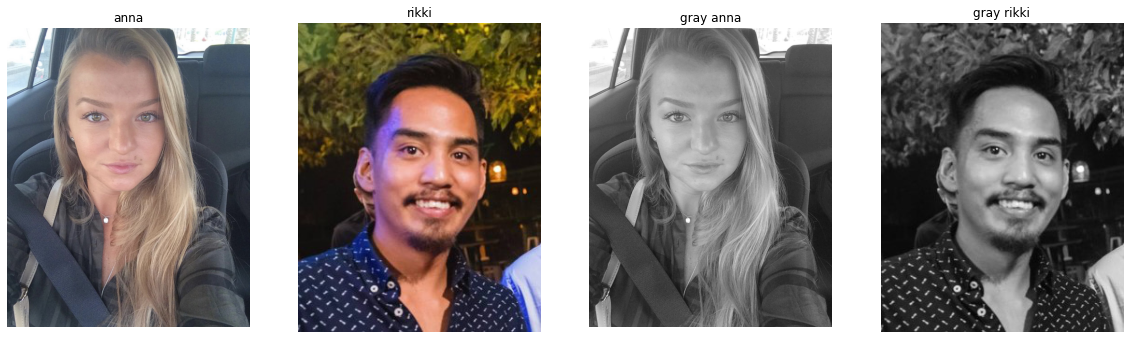

In [0]:
Im.show_all([img3, img4, g3, g4], ["anna", "rikki", "gray anna", "gray rikki"])

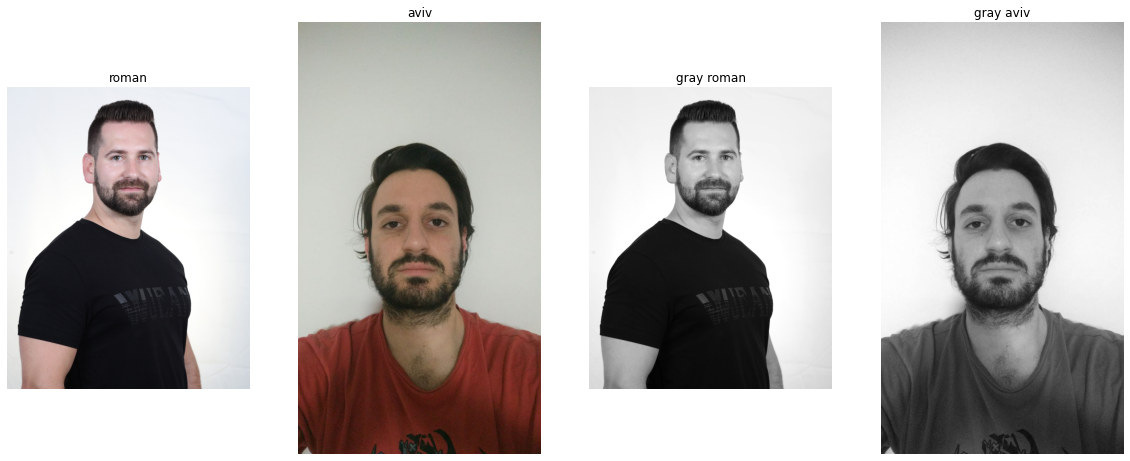

In [0]:
Im.show_all([img5, img6, g5, g6], ["roman", "aviv", "gray roman", "gray aviv"])

# **Detects faces in images**

In [0]:
def face_detect(img, thresh=0):
    # Clone the given image
    new_img = np.copy(img)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Convert into grayscale if needed
    if len(new_img.shape) == 3: # RGB
        gray = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
    elif len(new_img.shape) == 2: # Gray 
        gray = np.copy(new_img)       

    # Detect faces
    faces_coords = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(thresh, thresh))
    faces = list()
    all_coords = list()

    # Draw rectangle around the faces according to the given threshold size
    for coords in faces_coords:
        (x, y, w, h) = coords

        if len(new_img.shape) == 3: # RGB
            faces.append(img[y:y+h, x:x+w, :])
        elif len(new_img.shape) == 2: # Gray
            faces.append(img[y:y+h, x:x+w])

        all_coords.append(coords)
        cv2.rectangle(new_img, (x, y), (x + w, y + h), (0, 255, 255), 15)

    return new_img, np.asarray(faces), np.asarray(all_coords)

Face Detection examples

In [0]:
new_img1, faces1, c1 = face_detect(img1, 550)
new_img2, faces2, c2 = face_detect(img2, 1800)

new_gray_img1, gray_faces1, gray_c1 = face_detect(g1, 550)
new_gray_img2, gray_faces2, gray_c2 = face_detect(g2, 1800)

In [0]:
new_img3, faces3, c3 = face_detect(img3, 550)
new_img4, faces4, c4 = face_detect(img4)

new_gray_img3, gray_faces3, gray_c3 = face_detect(g3, 550)
new_gray_img4, gray_faces4, gray_c4 = face_detect(g4)

In [0]:
new_img5, faces5, c5 = face_detect(img5, 550)
new_img6, faces6, c6 = face_detect(img6)

new_gray_img5, gray_faces5, gray_c5 = face_detect(g5, 550)
new_gray_img6, gray_faces6, gray_c6 = face_detect(g6)

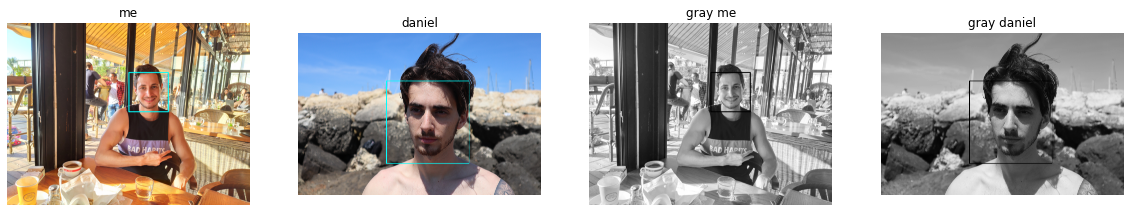

In [0]:
Im.show_all([new_img1, new_img2, new_gray_img1, new_gray_img2], ["me", "daniel", "gray me", "gray daniel"])

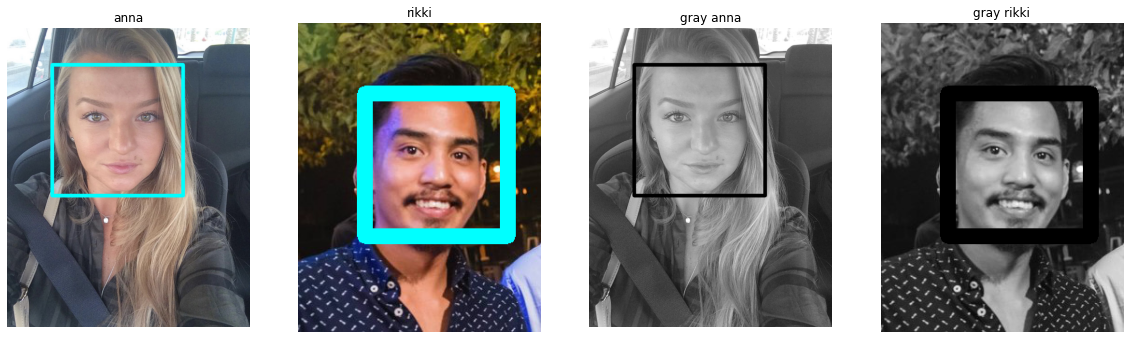

In [0]:
Im.show_all([new_img3, new_img4, new_gray_img3, new_gray_img4], ["anna", "rikki", "gray anna", "gray rikki"])

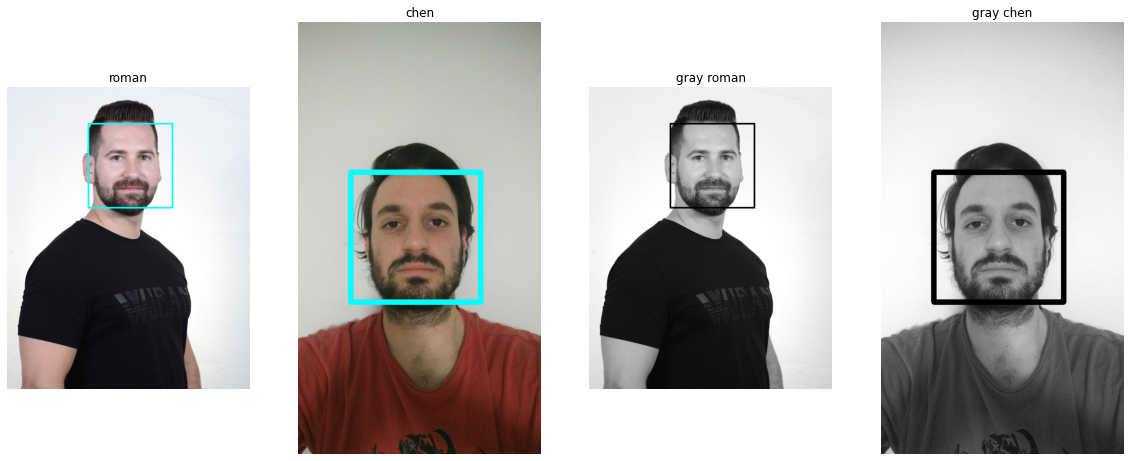

In [0]:
Im.show_all([new_img5, new_img6, new_gray_img5, new_gray_img6], ["roman", "chen", "gray roman", "gray chen"])

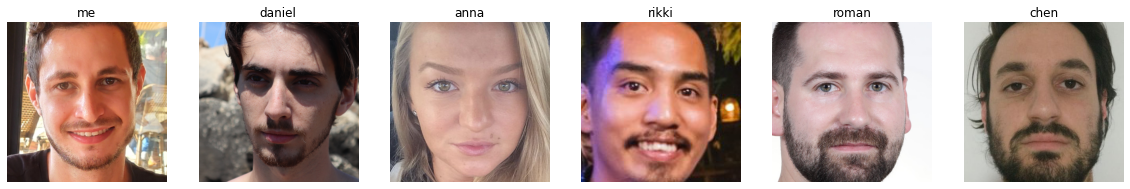

In [0]:
Im.show_all([faces1[0], faces2[0], faces3[0], faces4[0], faces5[0], faces6[0]], ["me", "daniel", "anna", "rikki", "roman", "chen"])

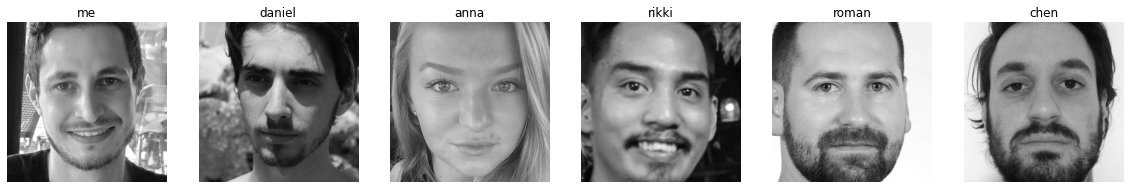

In [0]:
Im.show_all([gray_faces1[0], gray_faces2[0], gray_faces3[0], gray_faces4[0], gray_faces5[0], gray_faces6[0]], ["me", "daniel", "anna", "rikki", "roman", "chen"])

# **Defines segmentation function for faces isolation**

In [0]:
def foreground_segmentation(img):
    # Returns segmented image according to the given output that eliminates the background pixels

    new_img = np.copy(img)
    mask = np.zeros(img.shape[:2], np.uint8) # Face mask
    bgdModel = np.zeros((1, 65), np.float64) # Background model
    fgdModel = np.zeros((1, 65), np.float64) # Foreground model
    cropping_ratio = int(img.shape[0] * 0.07), int(img.shape[1] * 0.07)
    rect = (cropping_ratio[0], cropping_ratio[1], img.shape[0] - cropping_ratio[0], img.shape[1] - cropping_ratio[1])

    cv2.grabCut(new_img, mask, rect, bgdModel, fgdModel, 20, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8') # Makes background pixels 0

    return new_img * mask2[:, :, np.newaxis] # Gets the result image

In [0]:
def swap_face(src, dest, w_src=4, w_dest=1):
    assert len(src.shape) == len(dest.shape), "Images has different shape"
    # src - source image to extract face from
    # dest - destination image to replace its face
    # w_src - weight of face to copy, w_dest - weight of face to replace

    # Face detection
    new_src, src_faces, src_coords = face_detect(src)
    new_dest, dest_faces, dest_coords = face_detect(dest)

    # Find dominant face in src
    max_area_src_face = max(list(map(lambda face: face.shape[0] * face.shape[1], src_faces)))
    src_c = list(filter(lambda c: c[2] * c[3] == max_area_src_face, src_coords))[0] # Coordinations an distance
    src_f = list(filter(lambda face: face.shape[0] * face.shape[1] == max_area_src_face, src_faces))[0] # Face

    if len(src.shape) == 2: # OpenCV does not support gray images' segmentation
        src_f = cv2.cvtColor(src_f, cv2.COLOR_GRAY2RGB)
        src_f = foreground_segmentation(src_f) # Isolates background from foreground
        src_f = cv2.cvtColor(src_f, cv2.COLOR_RGB2GRAY)
    elif len(src.shape) == 3: # RGB image
        src_f = foreground_segmentation(src_f) # Isolates background from foreground

    # Find dominant face in dest
    max_area_dest_face = max(list(map(lambda face: face.shape[0] * face.shape[1], dest_faces)))
    dest_c = list(filter(lambda c: c[2] * c[3] == max_area_dest_face, dest_coords))[0] # Coordinations an distance
    dest_f = list(filter(lambda face: face.shape[0] * face.shape[1] == max_area_dest_face, dest_faces))[0] # # Face
    
    swapped_dest = np.copy(dest) # Will be the result image
    src_f_resized = cv2.resize(src_f, (dest_c[2], dest_c[3]), cv2.INTER_AREA) # Fit faces size

    if len(src.shape) == 2: # Gray image
        swapped_dest = swapped_dest[:, :, np.newaxis]
        src_f_resized = src_f_resized[:, :, np.newaxis]
        dest_ = dest[:, :, np.newaxis]
    elif len(src.shape) == 3: # RGB image
        dest_ = np.copy(dest)
        
    # Copies face in source image into destination image
    for i in range(src_f_resized.shape[0]):
        for j in range(src_f_resized.shape[1]):
            for c in range(src_f_resized.shape[2]):
                if src_f_resized[i][j][c] != 0:
                    swapped_dest[i + dest_c[1]][j + dest_c[0]][c] = (w_src * src_f_resized[i][j][c] + w_dest * dest_[i + dest_c[1]][j + dest_c[0]][c] ) // (w_src + w_dest)

    # Blurs the cropped area and attach it back
    # Takes other 15 pixels per direction to smooth the connections between the new face and the destination image
    cropped = swapped_dest[dest_c[1] - 15 : dest_c[1] + dest_c[3] + 15, dest_c[0] - 15 : dest_c[0] + dest_c[2] + 15, :]
    cropped = cv2.filter2D(cropped, -1, np.ones((5, 5), np.float32) / 25)

    if len(cropped.shape) == 2: # Gray image
        cropped = cropped[:, :, np.newaxis]

    # Broadcast cropped face in the fitting place
    swapped_dest[dest_c[1] - 15 : dest_c[1] + dest_c[3] + 15, dest_c[0] - 15 : dest_c[0] + dest_c[2] + 15, :] = cropped
    if swapped_dest.shape[2] == 1: # Squeeze dimension of gray image after adding axis above
        swapped_dest = np.squeeze(swapped_dest, axis=2)
    
    return swapped_dest

Face Swapping examples

In [0]:
s1 = swap_face(img2, img1) # RGB - eylon, daniel

In [0]:
gray_s1 = swap_face(g2, g1) # Gray - eylon, daniel

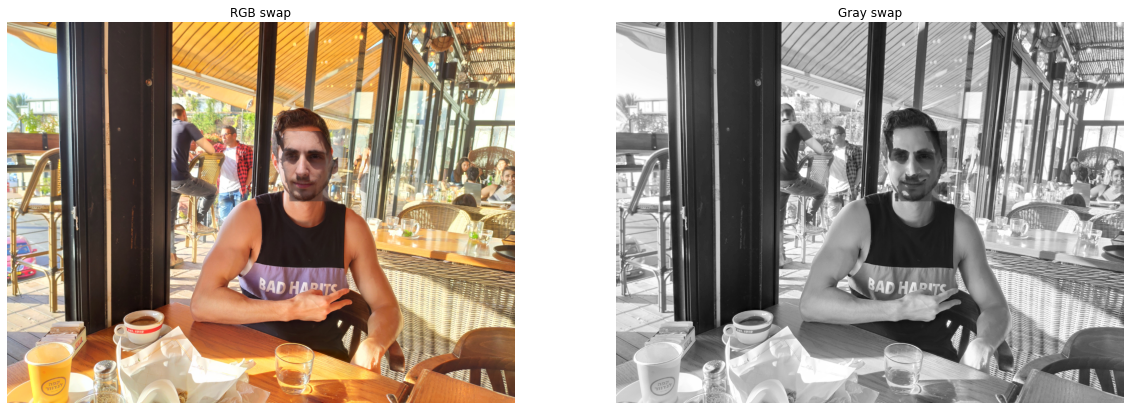

In [0]:
Im.show_all([s1, gray_s1], ["RGB swap", "Gray swap"])

In [0]:
s2 = swap_face(img3, img4) # RGB - rikki, anna

In [0]:
gray_s2 = swap_face(g3, g4) # Gray - rikki, anna

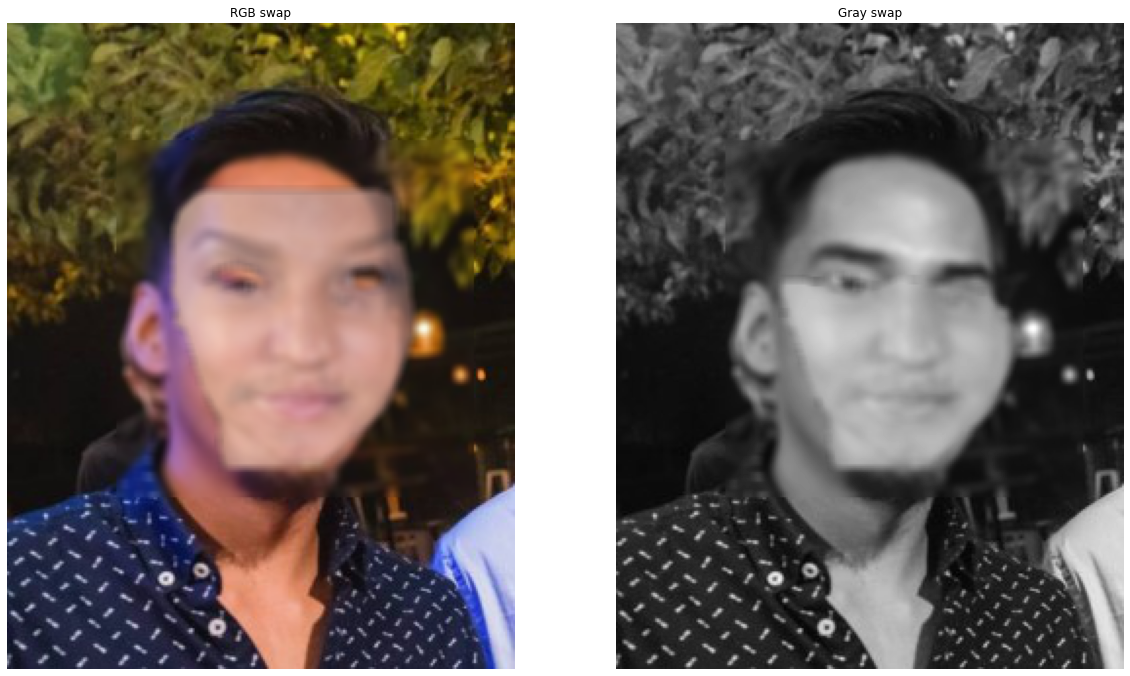

In [0]:
Im.show_all([s2, gray_s2], ["RGB swap", "Gray swap"])

In [0]:
s3 = swap_face(img6, img5) # RGB - chen, roman

In [0]:
gray_s3 = swap_face(g6, g5) # Gray - chen, roman

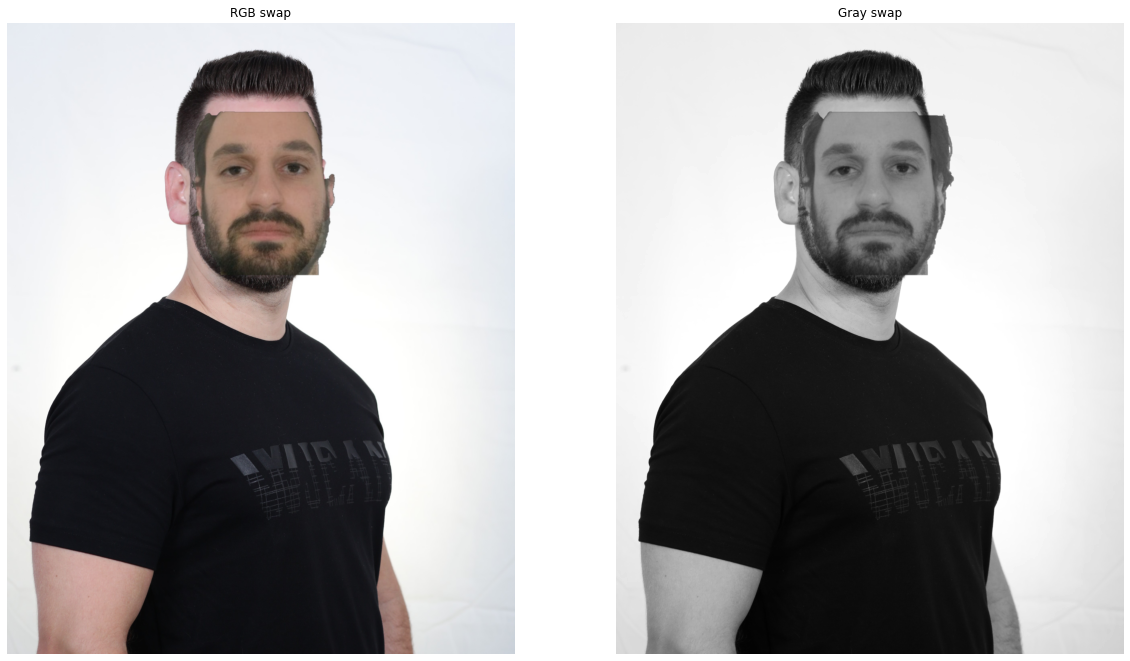

In [0]:
Im.show_all([s3, gray_s3], ["RGB swap", "Gray swap"])